<a href="https://colab.research.google.com/github/sujitpal/deeplearning-ai-examples/blob/master/blog_text_augment_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import operator
import os
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from google.colab import drive
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import base

from imblearn.over_sampling import SMOTE

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [2]:
# Mount Google Drive

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)           # we mount the google drive at /content/drive

/content/drive
Mounted at /content/drive


In [3]:
DATA_DIR = "/content/drive/MyDrive/nlp-deeplearning-ai-data"

# pre-split data splits prepared in previous (01) notebook
SPAM_TRAIN_FILE = os.path.join(DATA_DIR, "spam_train_emb.tsv")
SPAM_VALID_FILE = os.path.join(DATA_DIR, "spam_valid_emb.tsv")
SPAM_TEST_FILE = os.path.join(DATA_DIR, "spam_test_emb.tsv")

# only used for TextAttack experiment
SPAM_TA_TRAIN_FILE = os.path.join(DATA_DIR, "spam_train_ta_emb.tsv")

# CLF_LAYER_DIMS = [512, 1024, 256, 32, 2]
# CLF_LAYER_DIMS = [512, 1024, 128, 2]
# CLF_LAYER_DIMS = [512, 256, 128, 2]
# CLF_LAYER_DIMS = [512, 16, 8, 2]
CLF_LAYER_DIMS = [512, 128, 32, 2]
# CLF_LAYER_DIMS = [512, 1024, 64, 2]

BATCH_SIZE = 128
LEARNING_RATE = 1e-3
NUM_EPOCHS = 10

ACCURACY_STATS = []

In [4]:
spam_train_df = pd.read_csv(SPAM_TRAIN_FILE, sep='\t').dropna().reset_index()
spam_valid_df = pd.read_csv(SPAM_VALID_FILE, sep='\t').dropna().reset_index()
spam_test_df = pd.read_csv(SPAM_TEST_FILE, sep='\t').dropna().reset_index()

len(spam_train_df), len(spam_valid_df), len(spam_test_df)

(3900, 557, 1115)

In [5]:
spam_train_df.head()

,index,sentence,label,embedding
0,0,Ugh I don't wanna get out of bed. It's so warm.,ham,"5.3949911e-02,5.8220369e-03,-3.1541418e-02,3.3..."
1,1,Dear i have reache room,ham,"4.7420025e-02,2.3147971e-03,1.6905151e-02,-1.1..."
2,2,I always chat with you. In fact i need money c...,ham,"3.6402624e-02,-1.0346117e-01,5.0689392e-02,2.1..."
3,3,Yes just finished watching days of our lives. ...,ham,"1.6084902e-02,-1.7980557e-03,-4.4794872e-02,3...."
4,4,Nice.nice.how is it working?,ham,"-4.0968325e-02,-2.6070992e-02,-1.6136026e-02,-..."


In [6]:
spam_train_df["label"].value_counts()

ham     3355
spam     545
Name: label, dtype: int64

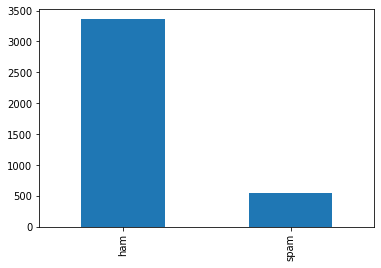

In [7]:
spam_train_df["label"].value_counts().plot(kind="bar")

## Baseline

In [8]:
def create_dataset(input_df):
  emb_vecs = []
  for emb in input_df["embedding"].values:
    vec = np.array([float(x) for x in str(emb).split(",")])
    emb_vecs.append(vec)
  labels = [0 if label == "ham" else 1 for label in input_df["label"].values]
  return TensorDataset(
      torch.tensor(np.array(emb_vecs), dtype=torch.float32),
      torch.tensor(np.array(labels), dtype=torch.long)
  )


train_ds = create_dataset(spam_train_df)
val_ds = create_dataset(spam_valid_df)
test_ds = create_dataset(spam_test_df)

In [9]:
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
class SpamClassifier(nn.Module):
  def __init__(self, dimensions):
    super(SpamClassifier, self).__init__()
    self.input_layer = nn.Linear(dimensions[0], dimensions[1])
    self.hidden_layers = nn.ModuleList()
    for i in range(1, len(dimensions) - 2):
      hidden_layer = nn.Linear(dimensions[i], dimensions[i + 1])
      self.hidden_layers.append(hidden_layer)
    self.output_layer = nn.Linear(dimensions[-2], dimensions[-1])

  def forward(self, x):
    x = F.relu(self.input_layer(x))
    for hidden_layer in self.hidden_layers:
      x = F.relu(hidden_layer(x))
    x = F.softmax(self.output_layer(x), dim=1)
    return x

clf = SpamClassifier(CLF_LAYER_DIMS)

# self-test
input = torch.rand(32, 512)
output = clf(input)
print(input.size(), output.size())

torch.Size([32, 512]) torch.Size([32, 2])


In [11]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clf = clf.to(dev)

In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(clf.parameters(), lr=LEARNING_RATE)

In [13]:
def train(train_dl, model, loss_fn, optimizer):
  model.train()
  train_loss, train_acc, num_batches = 0, 0, 0
  for data, labels in train_dl:
    data, labels = data.to(dev), labels.to(dev)

    logits = model(data)
    loss = loss_fn(logits, labels)

    train_loss += loss.item()
    _, preds = torch.max(logits.data, dim=1)
    train_acc += (preds == labels).sum() / labels.size()[0]
    num_batches += 1

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  return train_loss / num_batches, train_acc / num_batches

def validate(val_dl, model, loss_fn):
  model.eval()
  val_loss, val_acc, num_batches = 0, 0, 0
  for data, labels in val_dl:
    data, labels = data.to(dev), labels.to(dev)
    with torch.no_grad():
      logits = model(data)
      loss = loss_fn(logits, labels)

      val_loss += loss.item()
      _, preds = torch.max(logits.data, dim=1)
      val_acc += (preds == labels).sum() / labels.size()[0]
      num_batches += 1

  return val_loss / num_batches, val_acc / num_batches

In [14]:
train_losses, train_accs, val_losses, val_accs = [], [], [], []
for epoch in range(1, NUM_EPOCHS + 1):
  train_loss, train_acc = train(train_dl, clf, loss_fn, optimizer)
  val_loss, val_acc = validate(val_dl, clf, loss_fn) 
  print("EPOCH {:2d} | train_loss: {:.3f}, acc: {:.3f} | val_loss: {:.3f}, acc: {:.3f}"
    .format(epoch, train_loss, train_acc, val_loss, val_acc))
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  val_losses.append(val_loss)
  val_accs.append(val_acc)

EPOCH  1 | train_loss: 0.636, acc: 0.787 | val_loss: 0.510, acc: 0.887
EPOCH  2 | train_loss: 0.427, acc: 0.925 | val_loss: 0.362, acc: 0.970
EPOCH  3 | train_loss: 0.349, acc: 0.978 | val_loss: 0.338, acc: 0.978
EPOCH  4 | train_loss: 0.333, acc: 0.985 | val_loss: 0.335, acc: 0.977
EPOCH  5 | train_loss: 0.328, acc: 0.989 | val_loss: 0.333, acc: 0.980
EPOCH  6 | train_loss: 0.325, acc: 0.992 | val_loss: 0.333, acc: 0.981
EPOCH  7 | train_loss: 0.323, acc: 0.992 | val_loss: 0.333, acc: 0.980
EPOCH  8 | train_loss: 0.322, acc: 0.993 | val_loss: 0.332, acc: 0.980
EPOCH  9 | train_loss: 0.321, acc: 0.994 | val_loss: 0.333, acc: 0.981
EPOCH 10 | train_loss: 0.320, acc: 0.994 | val_loss: 0.333, acc: 0.980


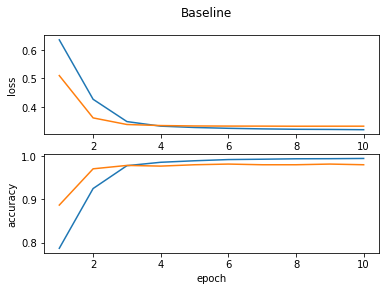

In [15]:
def training_lossplots(title, train_losses, train_accs, val_losses, val_accs):
  plt.subplot(2, 1, 1)
  epochs = np.arange(1, NUM_EPOCHS + 1)
  plt.plot(epochs, train_losses, label="train")
  plt.plot(epochs, val_losses, label="valid")
  plt.xlabel("epoch")
  plt.ylabel("loss")

  plt.subplot(2, 1, 2)
  plt.plot(epochs, train_accs, label="train")
  plt.plot(epochs, val_accs, label="valid")
  plt.xlabel("epoch")
  plt.ylabel("accuracy")

  plt.suptitle(title)
  _ = plt.show()


training_lossplots("Baseline", train_losses, train_accs, val_losses, val_accs)

In [16]:
def predict(test_dl, model):
  model.eval()
  predictions, labels = [], []
  for data, labels_b in val_dl:
    data, labels_b = data.to(dev), labels_b.to(dev)
    with torch.no_grad():
      logits = model(data)
      _, preds = torch.max(logits.data, dim=1)
      predictions.extend([p.item() for p in preds])
      labels.extend([l.item() for l in labels_b])

  return predictions, labels

predictions, labels = predict(test_dl, clf)

In [17]:
accuracy = accuracy_score(predictions, labels)
ACCURACY_STATS.append((1, "baseline", accuracy))

print("accuracy: {:.3f}".format(accuracy))
print("confusion matrix")
print(confusion_matrix(predictions, labels))

accuracy: 0.977
confusion matrix
[[482   7]
 [  6  62]]


## Class Weights

In [18]:
num_major = len(spam_train_df[spam_train_df["label"] == "ham"])
num_minor = len(spam_train_df[spam_train_df["label"] == "spam"])

weight_major = 1 / num_major
weight_minor = 1 / num_minor
total_weight = weight_major + weight_minor
class_weights = torch.tensor([weight_major / total_weight, weight_minor / total_weight])
class_weights = class_weights.to(dev)

class_weights

tensor([0.1397, 0.8603], device='cuda:0')

In [19]:
clf = SpamClassifier(CLF_LAYER_DIMS)
clf = clf.to(dev)

loss_fn = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(clf.parameters(), lr=LEARNING_RATE)

In [20]:
train_losses, train_accs, val_losses, val_accs = [], [], [], []
for epoch in range(1, NUM_EPOCHS + 1):
  train_loss, train_acc = train(train_dl, clf, loss_fn, optimizer)
  val_loss, val_acc = validate(val_dl, clf, loss_fn) 
  print("EPOCH {:2d} | train_loss: {:.3f}, acc: {:.3f} | val_loss: {:.3f}, acc: {:.3f}"
    .format(epoch, train_loss, train_acc, val_loss, val_acc))
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  val_losses.append(val_loss)
  val_accs.append(val_acc)

EPOCH  1 | train_loss: 0.639, acc: 0.952 | val_loss: 0.528, acc: 0.975
EPOCH  2 | train_loss: 0.426, acc: 0.971 | val_loss: 0.355, acc: 0.975
EPOCH  3 | train_loss: 0.352, acc: 0.975 | val_loss: 0.339, acc: 0.975
EPOCH  4 | train_loss: 0.341, acc: 0.984 | val_loss: 0.336, acc: 0.977
EPOCH  5 | train_loss: 0.337, acc: 0.983 | val_loss: 0.337, acc: 0.981
EPOCH  6 | train_loss: 0.334, acc: 0.988 | val_loss: 0.337, acc: 0.983
EPOCH  7 | train_loss: 0.330, acc: 0.989 | val_loss: 0.338, acc: 0.983
EPOCH  8 | train_loss: 0.328, acc: 0.991 | val_loss: 0.339, acc: 0.981
EPOCH  9 | train_loss: 0.327, acc: 0.993 | val_loss: 0.339, acc: 0.983
EPOCH 10 | train_loss: 0.327, acc: 0.992 | val_loss: 0.340, acc: 0.980


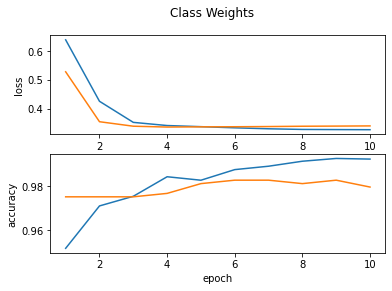

In [21]:
training_lossplots("Class Weights", train_losses, train_accs, val_losses, val_accs)

In [22]:
predictions, labels = predict(test_dl, clf)

accuracy = accuracy_score(predictions, labels)
ACCURACY_STATS.append((2, "class_weights", accuracy))

print("accuracy: {:.3f}".format(accuracy))
print("confusion matrix")
print(confusion_matrix(predictions, labels))

accuracy: 0.977
confusion matrix
[[479   4]
 [  9  65]]


## Undersampling Majority Class

Sampling (especially oversampling) must be restricted to the training split to protect against data leakage.

In [23]:
minor_df = spam_train_df[spam_train_df["label"] == "spam"]
num_minor = len(minor_df)
num_major = len(spam_train_df) - num_minor

sample_major_df = (
  spam_train_df[spam_train_df["label"] == "ham"]
  .sample(num_minor, replace=False, axis=0)
)

under_df = pd.concat([minor_df, sample_major_df], axis=0)
len(under_df)

1090

In [24]:
under_df["label"].value_counts()

spam    545
ham     545
Name: label, dtype: int64

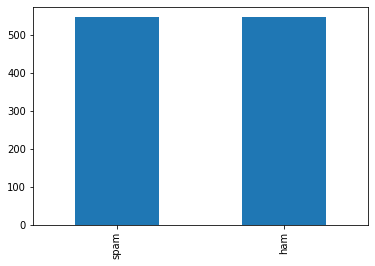

In [25]:
under_df["label"].value_counts().plot(kind="bar")

In [26]:
train_ds = create_dataset(under_df)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

In [27]:
clf = SpamClassifier(CLF_LAYER_DIMS)
clf = clf.to(dev)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(clf.parameters(), lr=LEARNING_RATE)

In [28]:
train_losses, train_accs, val_losses, val_accs = [], [], [], []
for epoch in range(1, NUM_EPOCHS + 1):
  train_loss, train_acc = train(train_dl, clf, loss_fn, optimizer)
  val_loss, val_acc = validate(val_dl, clf, loss_fn) 
  print("EPOCH {:2d} | train_loss: {:.3f}, acc: {:.3f} | val_loss: {:.3f}, acc: {:.3f}"
    .format(epoch, train_loss, train_acc, val_loss, val_acc))
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  val_losses.append(val_loss)
  val_accs.append(val_acc)

EPOCH  1 | train_loss: 0.688, acc: 0.495 | val_loss: 0.705, acc: 0.116
EPOCH  2 | train_loss: 0.661, acc: 0.666 | val_loss: 0.671, acc: 0.827
EPOCH  3 | train_loss: 0.610, acc: 0.937 | val_loss: 0.613, acc: 0.930
EPOCH  4 | train_loss: 0.529, acc: 0.955 | val_loss: 0.528, acc: 0.952
EPOCH  5 | train_loss: 0.449, acc: 0.964 | val_loss: 0.440, acc: 0.972
EPOCH  6 | train_loss: 0.393, acc: 0.965 | val_loss: 0.385, acc: 0.977
EPOCH  7 | train_loss: 0.365, acc: 0.971 | val_loss: 0.362, acc: 0.981
EPOCH  8 | train_loss: 0.352, acc: 0.975 | val_loss: 0.351, acc: 0.983
EPOCH  9 | train_loss: 0.347, acc: 0.973 | val_loss: 0.347, acc: 0.983
EPOCH 10 | train_loss: 0.343, acc: 0.977 | val_loss: 0.346, acc: 0.981


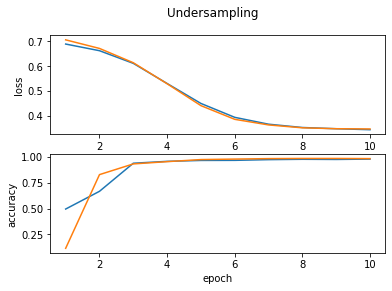

In [29]:
training_lossplots("Undersampling", train_losses, train_accs, val_losses, val_accs)

In [30]:
predictions, labels = predict(test_dl, clf)

accuracy = accuracy_score(predictions, labels)
ACCURACY_STATS.append((3, "under_sampling", accuracy))

print("accuracy: {:.3f}".format(accuracy))
print("confusion matrix")
print(confusion_matrix(predictions, labels))

accuracy: 0.978
confusion matrix
[[477   1]
 [ 11  68]]


## Oversampling Minority Class

In [31]:
major_df = spam_train_df[spam_train_df["label"] == "ham"]
num_major = len(major_df)
num_minor = len(spam_train_df) - num_major

sample_minor_df = spam_train_df[spam_train_df["label"] == "spam"].sample(
    num_major, replace=True, axis=0)

over_df = pd.concat([major_df, sample_minor_df], axis=0)
len(over_df)

6710

In [32]:
over_df["label"].value_counts()

spam    3355
ham     3355
Name: label, dtype: int64

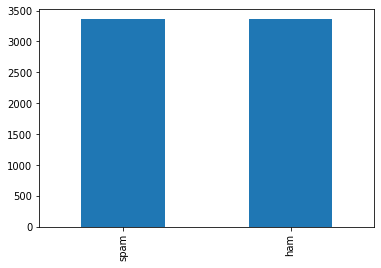

In [33]:
over_df["label"].value_counts().plot(kind="bar")

In [34]:
train_ds = create_dataset(over_df)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

In [35]:
clf = SpamClassifier(CLF_LAYER_DIMS)
clf = clf.to(dev)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(clf.parameters(), lr=LEARNING_RATE)

In [36]:
train_losses, train_accs, val_losses, val_accs = [], [], [], []
for epoch in range(1, NUM_EPOCHS + 1):
  train_loss, train_acc = train(train_dl, clf, loss_fn, optimizer)
  val_loss, val_acc = validate(val_dl, clf, loss_fn) 
  print("EPOCH {:2d} | train_loss: {:.3f}, acc: {:.3f} | val_loss: {:.3f}, acc: {:.3f}"
    .format(epoch, train_loss, train_acc, val_loss, val_acc))
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  val_losses.append(val_loss)
  val_accs.append(val_acc)

EPOCH  1 | train_loss: 0.561, acc: 0.927 | val_loss: 0.411, acc: 0.972
EPOCH  2 | train_loss: 0.357, acc: 0.971 | val_loss: 0.343, acc: 0.977
EPOCH  3 | train_loss: 0.337, acc: 0.981 | val_loss: 0.333, acc: 0.981
EPOCH  4 | train_loss: 0.330, acc: 0.986 | val_loss: 0.332, acc: 0.983
EPOCH  5 | train_loss: 0.328, acc: 0.988 | val_loss: 0.332, acc: 0.981
EPOCH  6 | train_loss: 0.326, acc: 0.989 | val_loss: 0.332, acc: 0.980
EPOCH  7 | train_loss: 0.325, acc: 0.989 | val_loss: 0.332, acc: 0.980
EPOCH  8 | train_loss: 0.325, acc: 0.989 | val_loss: 0.333, acc: 0.978
EPOCH  9 | train_loss: 0.324, acc: 0.989 | val_loss: 0.332, acc: 0.978
EPOCH 10 | train_loss: 0.324, acc: 0.989 | val_loss: 0.332, acc: 0.980


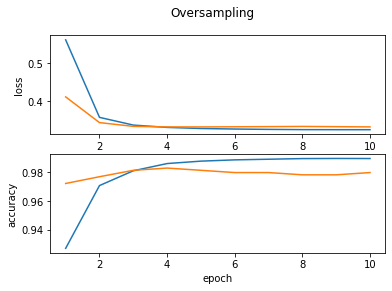

In [37]:
training_lossplots("Oversampling", train_losses, train_accs, val_losses, val_accs)

In [38]:
predictions, labels = predict(test_dl, clf)

accuracy = accuracy_score(predictions, labels)
ACCURACY_STATS.append((4, "over_sampling", accuracy))

print("accuracy: {:.3f}".format(accuracy))
print("confusion matrix")
print(confusion_matrix(predictions, labels))

accuracy: 0.977
confusion matrix
[[480   5]
 [  8  64]]


## SMOTE Oversampling

In [39]:
def create_xy_from_dataframe(input_df):
  emb_vecs = []
  for emb in input_df["embedding"].values:
    vec = np.array([float(x) for x in str(emb).split(",")])
    emb_vecs.append(vec)
  labels = [0 if label == "ham" else 1 for label in input_df["label"].values]
  return np.array(emb_vecs), np.array(labels)


def create_dataset_from_xy(xs, ys):
  return TensorDataset(
      torch.tensor(xs, dtype=torch.float32),
      torch.tensor(ys, dtype=torch.long)
  )


train_x, train_y = create_xy_from_dataframe(spam_train_df)
oversampler = SMOTE()
train_x, train_y = oversampler.fit_resample(train_x, train_y)
uniq, counts = np.unique(train_y, return_counts=True)
counts

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


array([3355, 3355])

In [40]:
train_ds = create_dataset_from_xy(train_x, train_y)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

In [41]:
clf = SpamClassifier(CLF_LAYER_DIMS)
clf = clf.to(dev)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(clf.parameters(), lr=LEARNING_RATE)

In [42]:
train_losses, train_accs, val_losses, val_accs = [], [], [], []
for epoch in range(1, NUM_EPOCHS + 1):
  train_loss, train_acc = train(train_dl, clf, loss_fn, optimizer)
  val_loss, val_acc = validate(val_dl, clf, loss_fn) 
  print("EPOCH {:2d} | train_loss: {:.3f}, acc: {:.3f} | val_loss: {:.3f}, acc: {:.3f}"
    .format(epoch, train_loss, train_acc, val_loss, val_acc))
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  val_losses.append(val_loss)
  val_accs.append(val_acc)

EPOCH  1 | train_loss: 0.553, acc: 0.887 | val_loss: 0.371, acc: 0.977
EPOCH  2 | train_loss: 0.343, acc: 0.979 | val_loss: 0.336, acc: 0.981
EPOCH  3 | train_loss: 0.330, acc: 0.986 | val_loss: 0.333, acc: 0.981
EPOCH  4 | train_loss: 0.326, acc: 0.990 | val_loss: 0.333, acc: 0.981
EPOCH  5 | train_loss: 0.323, acc: 0.991 | val_loss: 0.333, acc: 0.981
EPOCH  6 | train_loss: 0.321, acc: 0.994 | val_loss: 0.333, acc: 0.981
EPOCH  7 | train_loss: 0.320, acc: 0.995 | val_loss: 0.332, acc: 0.981
EPOCH  8 | train_loss: 0.319, acc: 0.995 | val_loss: 0.333, acc: 0.981
EPOCH  9 | train_loss: 0.318, acc: 0.996 | val_loss: 0.334, acc: 0.981
EPOCH 10 | train_loss: 0.318, acc: 0.996 | val_loss: 0.332, acc: 0.981


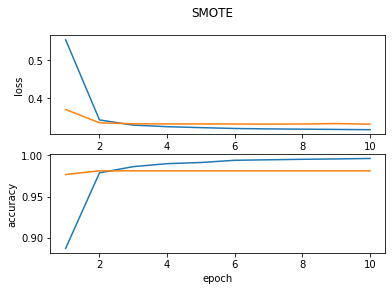

In [43]:
training_lossplots("SMOTE", train_losses, train_accs, val_losses, val_accs)

In [44]:
predictions, labels = predict(test_dl, clf)

accuracy = accuracy_score(predictions, labels)
ACCURACY_STATS.append((5, "SMOTE", accuracy))

print("accuracy: {:.3f}".format(accuracy))
print("confusion matrix")
print(confusion_matrix(predictions, labels))

accuracy: 0.978
confusion matrix
[[481   5]
 [  7  64]]


## Text Attack Augmentation

In [45]:
spam_train_df = pd.read_csv(SPAM_TA_TRAIN_FILE, sep='\t')
spam_train_df.head()

,sentence,label,embedding
0,Ugh I don't wanna get out of bed. It's so warm.,ham,"5.3949911e-02,5.8220369e-03,-3.1541418e-02,3.3..."
1,Dear i have reache room,ham,"4.7420025e-02,2.3147971e-03,1.6905151e-02,-1.1..."
2,I always chat with you. In fact i need money c...,ham,"3.6402624e-02,-1.0346117e-01,5.0689392e-02,2.1..."
3,Yes just finished watching days of our lives. ...,ham,"1.6084902e-02,-1.7980557e-03,-4.4794872e-02,3...."
4,Nice.nice.how is it working?,ham,"-4.0968325e-02,-2.6070992e-02,-1.6136026e-02,-..."


In [46]:
spam_train_df["label"].value_counts()

ham     3355
spam    2712
Name: label, dtype: int64

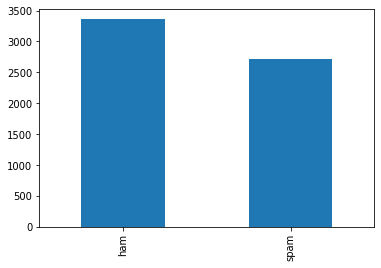

In [47]:
spam_train_df["label"].value_counts().plot(kind="bar")

In [48]:
train_ds = create_dataset(spam_train_df)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

In [49]:
clf = SpamClassifier(CLF_LAYER_DIMS)
clf = clf.to(dev)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(clf.parameters(), lr=LEARNING_RATE)

In [50]:
train_losses, train_accs, val_losses, val_accs = [], [], [], []
for epoch in range(1, NUM_EPOCHS + 1):
  train_loss, train_acc = train(train_dl, clf, loss_fn, optimizer)
  val_loss, val_acc = validate(val_dl, clf, loss_fn) 
  print("EPOCH {:2d} | train_loss: {:.3f}, acc: {:.3f} | val_loss: {:.3f}, acc: {:.3f}"
    .format(epoch, train_loss, train_acc, val_loss, val_acc))
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  val_losses.append(val_loss)
  val_accs.append(val_acc)

EPOCH  1 | train_loss: 0.581, acc: 0.802 | val_loss: 0.383, acc: 0.974
EPOCH  2 | train_loss: 0.357, acc: 0.970 | val_loss: 0.340, acc: 0.978
EPOCH  3 | train_loss: 0.341, acc: 0.976 | val_loss: 0.339, acc: 0.981
EPOCH  4 | train_loss: 0.336, acc: 0.979 | val_loss: 0.335, acc: 0.980
EPOCH  5 | train_loss: 0.333, acc: 0.982 | val_loss: 0.336, acc: 0.977
EPOCH  6 | train_loss: 0.331, acc: 0.984 | val_loss: 0.339, acc: 0.971
EPOCH  7 | train_loss: 0.329, acc: 0.986 | val_loss: 0.338, acc: 0.971
EPOCH  8 | train_loss: 0.328, acc: 0.987 | val_loss: 0.338, acc: 0.975
EPOCH  9 | train_loss: 0.327, acc: 0.987 | val_loss: 0.339, acc: 0.969
EPOCH 10 | train_loss: 0.326, acc: 0.988 | val_loss: 0.341, acc: 0.971


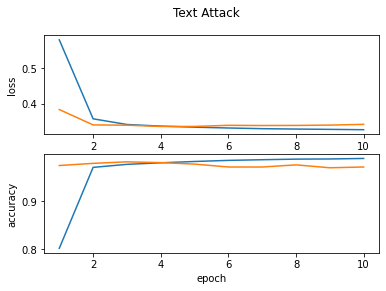

In [51]:
training_lossplots("Text Attack", train_losses, train_accs, val_losses, val_accs)

In [52]:
predictions, labels = predict(test_dl, clf)

accuracy = accuracy_score(predictions, labels)
ACCURACY_STATS.append((6, "text_attack", accuracy))

print("accuracy: {:.3f}".format(accuracy))
print("confusion matrix")
print(confusion_matrix(predictions, labels))

accuracy: 0.969
confusion matrix
[[475   4]
 [ 13  65]]


### Results

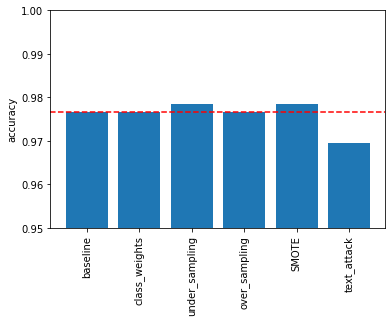

In [53]:
accuracy_stats = sorted(ACCURACY_STATS, key=operator.itemgetter(0))
xs = [x[1] for x in accuracy_stats]
ys = [x[2] for x in accuracy_stats]

plt.bar(np.arange(len(xs)), ys)
plt.axhline(y=ys[0], color="r", linestyle="--", linewidth=1.5)
plt.ylabel("accuracy")
plt.xticks(np.arange(len(xs)), xs, rotation="90")
plt.ylim([0.95, 1.0])

_ = plt.show()

In [54]:
result_df = pd.DataFrame(ACCURACY_STATS, columns=["expt_num", "expt_name", "accuracy"])
result_df.head(len(result_df))

,expt_num,expt_name,accuracy
0,1,baseline,0.976661
1,2,class_weights,0.976661
2,3,under_sampling,0.978456
3,4,over_sampling,0.976661
4,5,SMOTE,0.978456
5,6,text_attack,0.969479
